In [ ]:
#import required libraries
import rasterio
import os
import json
import random
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [2]:
# specify the path to your main folder containing the subfolders with TIFF images
dataset_path = r"C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\patches"

# get a list of all TIFF images in the main folder and its subfolders
tiff_files = glob.glob(os.path.join(dataset_path, '**/*.tif'), recursive=True)

# function to extract numbers from a string
def get_numeric_value(text):
    return int(''.join(re.findall(r'\d+', text)))

# sort the list in ascending order based on the numbers in the filenames
tiff_files.sort(key=get_numeric_value)

# create a dictionary to store images
image_data = {}

# load each image into the dictionary
for index in range(0, len(tiff_files), 3):  # start at first image, end at last image, step by 3
    tiff_file = tiff_files[index]
    with rasterio.open(tiff_file) as img:
        # get the base name of the file without the extension
        file_name = os.path.basename(tiff_file)
        image_data[file_name] = img.read()

print("Number of images loaded: ", len(image_data))


Number of images loaded:  1381


In [3]:
# specify the path to your labels_mapping.txt file
mapping_file_path = r"C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\labels_mapping.txt"

# load the labels_mapping.txt file
with open(mapping_file_path, 'r') as file:
    label_mappings = json.load(file)

# now 'label_mappings' is a dictionary where the keys are the filenames and the values are the lists of labels

# create a dictionary to store images with their labels
image_labels = {}

# load each image into the dictionary with its label
for img_name, img_data in image_data.items():
    # get the base name of the file without the extension
    file_base_name = os.path.basename(img_name)
    # get the label for this image
    assigned_labels = label_mappings.get(file_base_name)
    if assigned_labels is None:
        print(f"No label found for image: {file_base_name}")
    # add the image and its label to the dictionary
    image_labels[img_name] = {'image': img_data, 'label': assigned_labels}

# print the labels for the loaded images
for img_name, img_info in image_labels.items():
    print(f"Filename: {img_name}, Label: {img_info['label']}")


Filename: S2_3-1-21_18QYF_0.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Filename: S2_3-1-21_18QYF_1.tif, Label: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Filename: S2_3-1-21_18QYF_2.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Filename: S2_3-1-21_18QYF_3.tif, Label: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Filename: S2_3-1-21_18QYF_4.tif, Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_0.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_1.tif, Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_2.tif, Label: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_3.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_4.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Filename: S2_4-3-18_50LLR_5.tif, Label: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Filename: S2_4-3-18_50LLR_6.tif, Label: [0, 0, 0, 0, 0

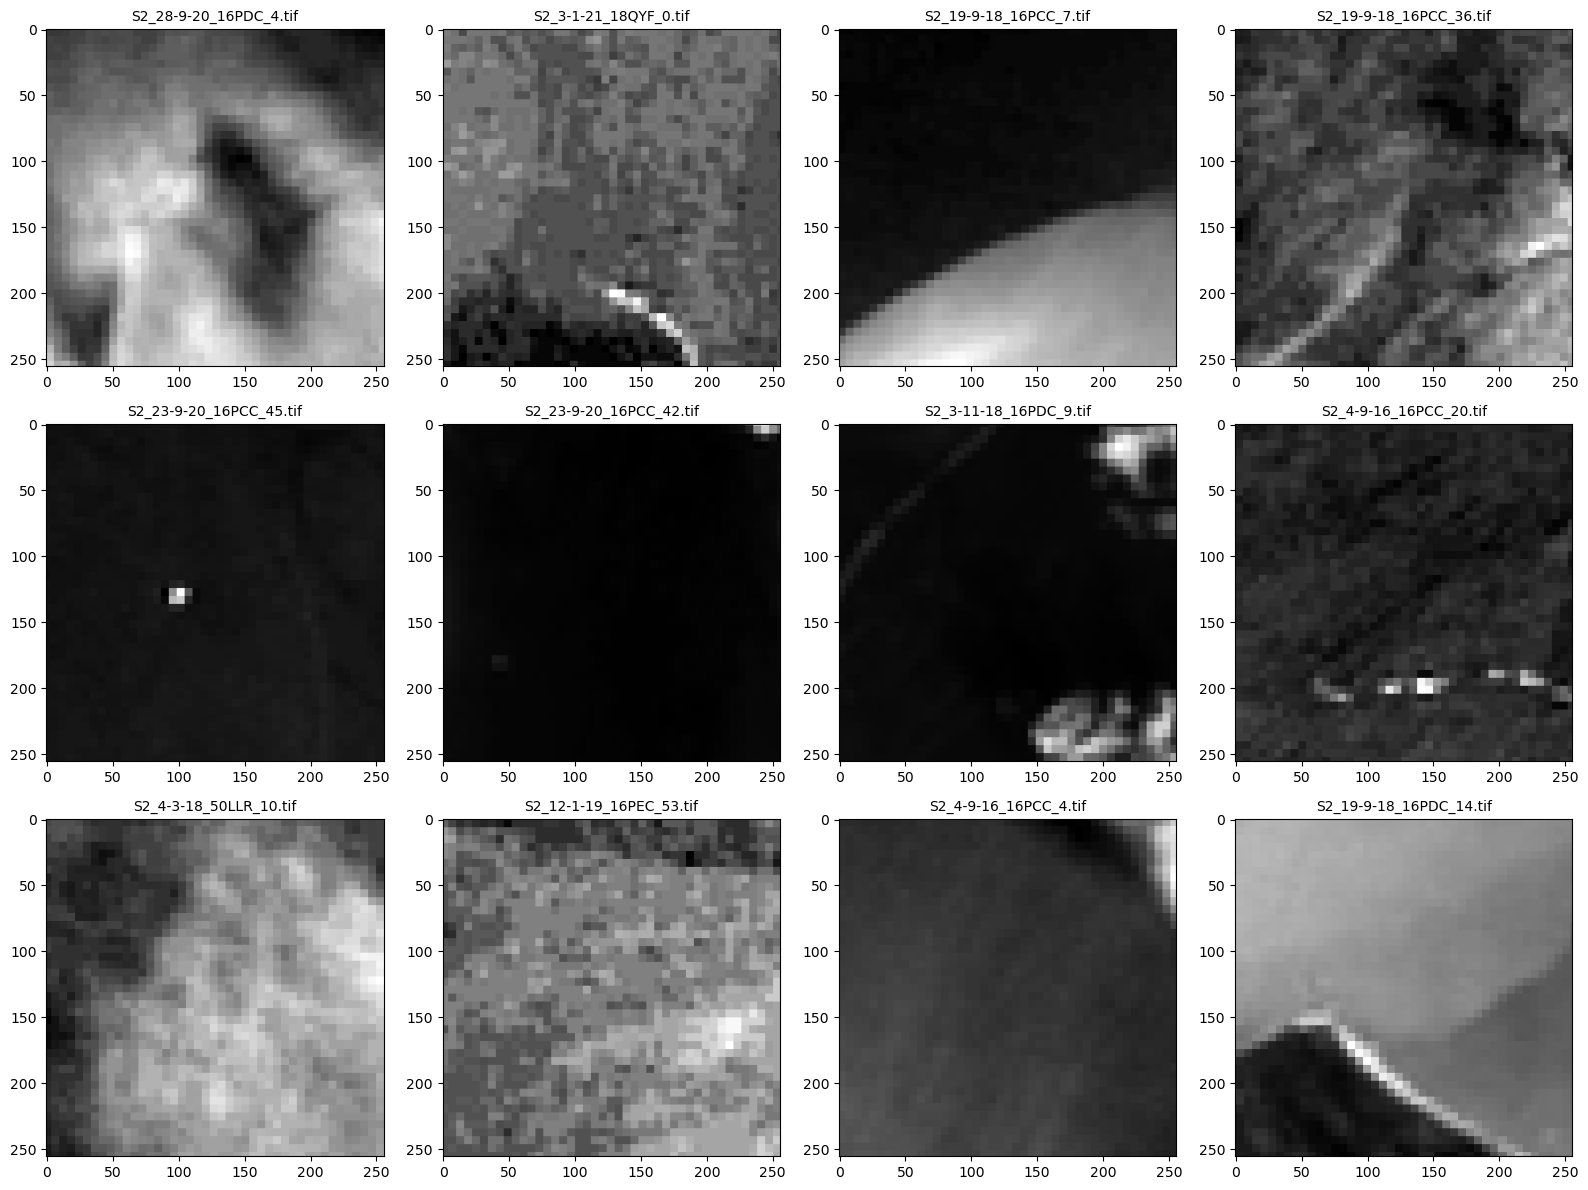

In [4]:
# Set the number of rows and columns for the subplot grid
grid_cols = 4
grid_rows = 3

# Create a new figure with a larger size
figure = plt.figure(figsize=(grid_cols * 4, grid_rows * 4))

# Ensure there are enough images to sample from
total_images = 12  # In case there are fewer than 12 images

# Select a random sample of 12 images
sampled_images = random.sample(list(image_data.items()), total_images)

# Iterate over the randomly selected images
for index, (img_filename, img_array) in enumerate(sampled_images):
    # Convert the image data to a numpy array
    img_numpy = np.array(img_array)

    # If the image has multiple bands, select the first one
    if img_numpy.ndim > 2:
        img_numpy = img_numpy[0, :, :]  # Selecting the first band for visualization

    # Extract the image name from the path
    img_name = os.path.basename(img_filename)

    # Add a subplot for the current image
    axis = figure.add_subplot(grid_rows, grid_cols, index + 1)
    axis.imshow(img_numpy, cmap='gray')
    axis.set_title(img_name, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


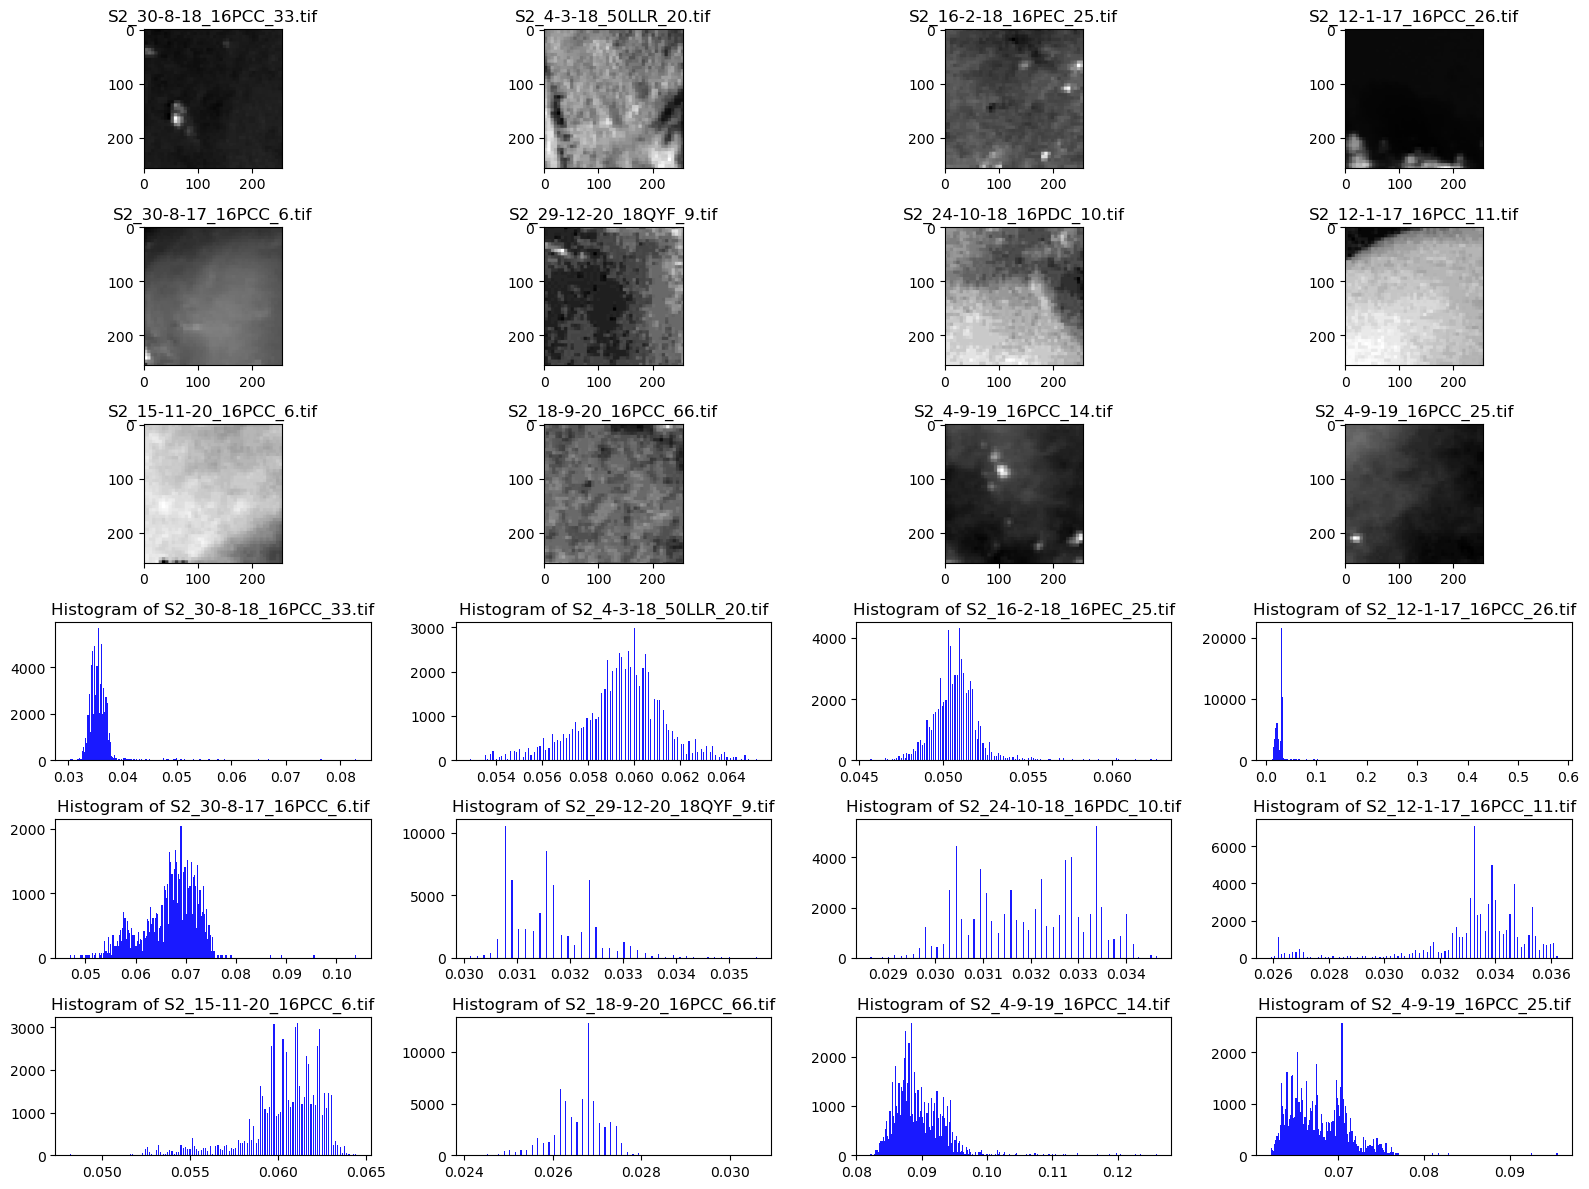

In [5]:
# Set the number of rows and columns for the subplot grid
grid_cols = 4
grid_rows = 3

# Create a new figure with a larger size
fig, axes = plt.subplots(grid_rows * 2, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))

# Ensure there are enough images to sample from
sampled_images_count = min(12, len(image_data))  # In case there are fewer than 12 images

# Select a random sample of images
selected_images = random.sample(list(image_data.items()), sampled_images_count)

# Iterate over the selected images
for index, (img_filename, img_array) in enumerate(selected_images):
    # Convert the image data to a numpy array
    img_numpy = np.array(img_array)

    # If the image has multiple bands, select the first one
    if img_numpy.ndim > 2:
        img_numpy = img_numpy[0, :, :]  # Selecting the first band for visualization

    # Extract the image name from the path
    img_name = os.path.basename(img_filename)

    # Add a subplot for the current image (top row)
    axis = axes[index // grid_cols, index % grid_cols]
    axis.imshow(img_numpy, cmap='gray')
    axis.set_title(img_name)

    # Create a histogram for the current image (bottom row)
    hist_axis = axes[index // grid_cols + grid_rows, index % grid_cols]
    hist_axis.hist(img_numpy.ravel(), bins=256, color='blue', alpha=0.9)
    hist_axis.set_title(f'Histogram of {img_name}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


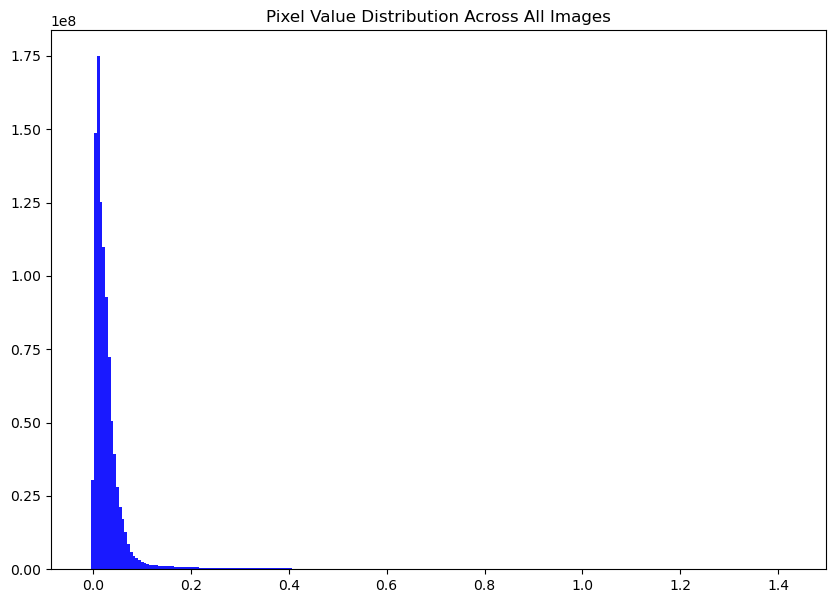

In [6]:
# Flatten all image data into one list
all_image_pixels = [np.array(img_data).ravel() for img_filename, img_data in image_data.items()]
all_image_pixels = np.concatenate(all_image_pixels)

# Plot pixel value distribution
plt.figure(figsize=(10, 7))
plt.hist(all_image_pixels, bins=256, color='blue', alpha=0.9)
plt.title('Pixel Value Distribution Across All Images')
plt.show()


In [7]:
# Create a dictionary to map class indices to names
category_names = {
    1: 'Marine Debris',
    2: 'Dense Sargassum',
    3: 'Sparse Sargassum',
    4: 'Natural Organic Material',
    5: 'Ship',
    6: 'Clouds',
    7: 'Marine Water',
    8: 'Sediment-Laden Water',
    9: 'Foam',
    10: 'Turbid Water',
    11: 'Shallow Water',
    12: 'Waves',
    13: 'Cloud Shadows',
    14: 'Wakes',
    15: 'Mixed Water'
}

# Print out the class labels for each image
for img_filename, img_info in image_labels.items():
    # Get the class indices for this image
    class_indices = img_info['label']
    # Map the class indices to names
    class_labels = [category_names[i+1] for i, present in enumerate(class_indices) if present]
    print(f"Image: {os.path.basename(img_filename)}, Classes: {class_labels}")


Image: S2_3-1-21_18QYF_0.tif, Classes: ['Marine Debris', 'Marine Water', 'Mixed Water']
Image: S2_3-1-21_18QYF_1.tif, Classes: ['Marine Debris', 'Natural Organic Material', 'Marine Water', 'Mixed Water']
Image: S2_3-1-21_18QYF_2.tif, Classes: ['Marine Debris', 'Marine Water', 'Mixed Water']
Image: S2_3-1-21_18QYF_3.tif, Classes: ['Marine Water']
Image: S2_3-1-21_18QYF_4.tif, Classes: ['Shallow Water']
Image: S2_4-3-18_50LLR_0.tif, Classes: ['Marine Debris', 'Marine Water']
Image: S2_4-3-18_50LLR_1.tif, Classes: ['Shallow Water']
Image: S2_4-3-18_50LLR_2.tif, Classes: ['Marine Debris', 'Natural Organic Material', 'Marine Water']
Image: S2_4-3-18_50LLR_3.tif, Classes: ['Marine Debris', 'Marine Water']
Image: S2_4-3-18_50LLR_4.tif, Classes: ['Marine Debris', 'Marine Water', 'Foam']
Image: S2_4-3-18_50LLR_5.tif, Classes: ['Marine Debris', 'Marine Water', 'Mixed Water']
Image: S2_4-3-18_50LLR_6.tif, Classes: ['Marine Water']
Image: S2_4-3-18_50LLR_7.tif, Classes: ['Marine Debris', 'Natural 

In [8]:
# Create a dictionary to hold the counts for each category
category_counts = {category_name: 0 for category_name in category_names.values()}

# Iterate over all labeled images and count the categories
for img_filename, img_info in image_labels.items():
    # Get the class indices for this image
    class_indices = img_info['label']
    # Map the class indices to names
    categories_for_image = [category_names[i+1] for i, present in enumerate(class_indices) if present]
    # Increment the count for each category
    for category_name in categories_for_image:
        category_counts[category_name] += 1

# Print out the counts for each category
for category_name, count in category_counts.items():
    print(f"Category: {category_name}, Number of Images: {count}")


Category: Marine Debris, Number of Images: 373
Category: Dense Sargassum, Number of Images: 49
Category: Sparse Sargassum, Number of Images: 106
Category: Natural Organic Material, Number of Images: 71
Category: Ship, Number of Images: 182
Category: Clouds, Number of Images: 181
Category: Marine Water, Number of Images: 870
Category: Sediment-Laden Water, Number of Images: 51
Category: Foam, Number of Images: 59
Category: Turbid Water, Number of Images: 220
Category: Shallow Water, Number of Images: 64
Category: Waves, Number of Images: 54
Category: Cloud Shadows, Number of Images: 71
Category: Wakes, Number of Images: 106
Category: Mixed Water, Number of Images: 140


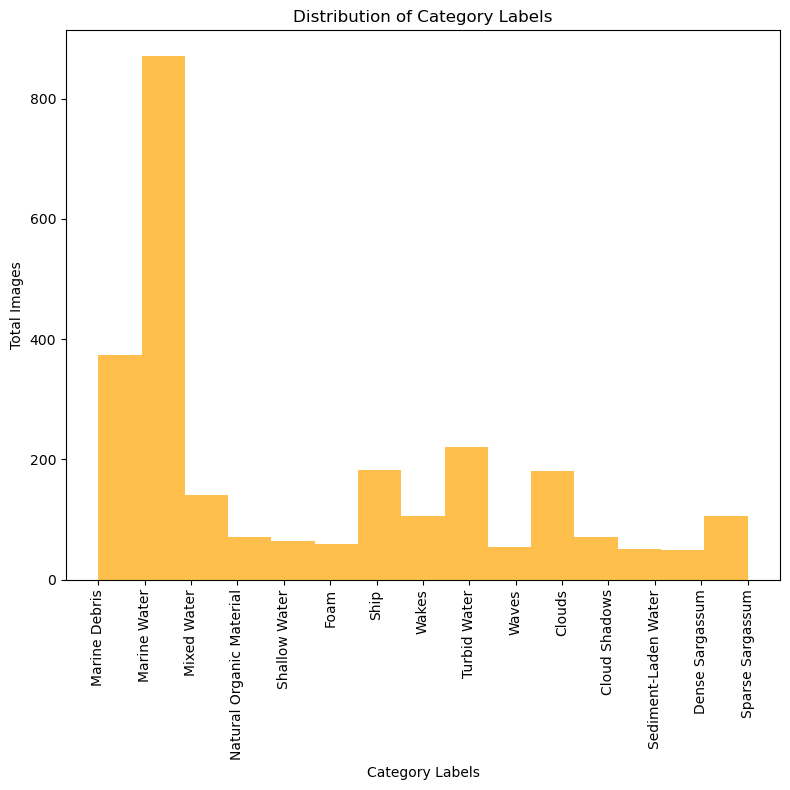

In [9]:
# Create a list to hold all category labels
all_category_labels = []

# Iterate over all labeled images and add their labels to the list
for img_filename, img_info in image_labels.items():
    # Get the class indices for this image
    class_indices = img_info['label']
    # Map the class indices to names
    categories_for_image = [category_names[i+1] for i, present in enumerate(class_indices) if present]
    all_category_labels.extend(categories_for_image)

# Create a histogram of category labels
plt.figure(figsize=(8,8))
plt.hist(all_category_labels, bins=len(category_names), color='orange', alpha=0.7)
plt.xticks(rotation='vertical')
plt.title('Distribution of Category Labels')
plt.xlabel('Category Labels')
plt.ylabel('Total Images')
plt.tight_layout()
plt.show()


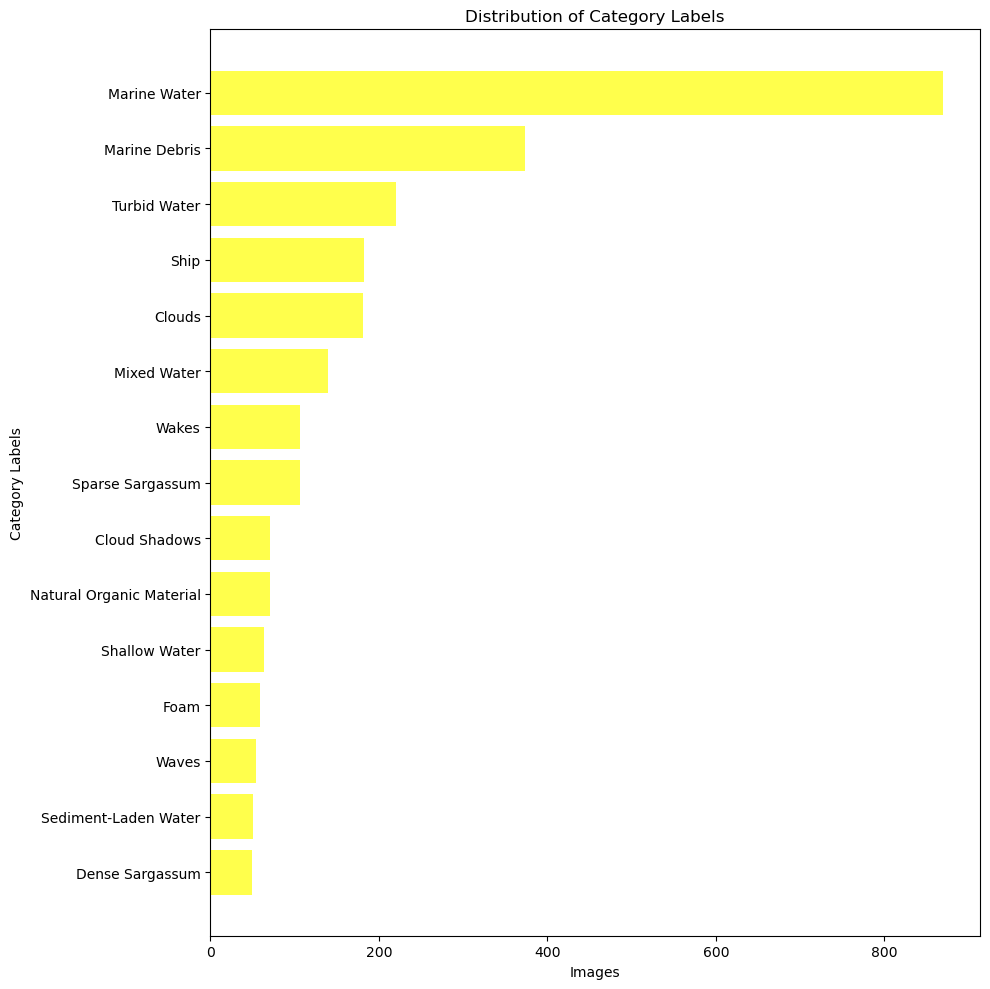

In [10]:
# Create a dictionary to hold the counts for each category
category_counts = {category_name: 0 for category_name in category_names.values()}

# Iterate over all labeled images and count the categories
for img_filename, img_info in image_labels.items():
    # Get the class indices for this image
    class_indices = img_info['label']
    # Map the class indices to names
    categories_for_image = [category_names[i+1] for i, present in enumerate(class_indices) if present]
    # Increment the count for each category
    for category_name in categories_for_image:
        category_counts[category_name] += 1

# Sort the categories by counts
sorted_categories = sorted(category_counts.items(), key=lambda item: item[1])

# Plot a stacked bar chart of category distributions
plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_categories)), [count for category_name, count in sorted_categories], color='yellow', alpha=0.7)
plt.yticks(range(len(sorted_categories)), [category_name for category_name, count in sorted_categories])
plt.title('Distribution of Category Labels')
plt.xlabel('Images')
plt.ylabel('Category Labels')
plt.tight_layout()
plt.show()


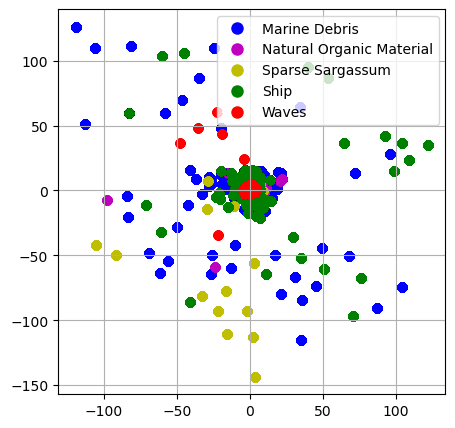

In [11]:
# Define a generator function to process images in chunks
def process_image_chunks(image_data, chunk_size=100):
    for i in range(0, len(image_data), chunk_size):
        chunk_data = []
        chunk_labels = []
        chunk = list(image_data.items())[i:i+chunk_size]
        for img_filename, img_info in chunk:
            flattened_img = img_info['image'].flatten()
            chunk_data.append(flattened_img)
            # Get the class indices for this image
            class_indices = img_info['label']
            # Map the class indices to names
            class_names_for_img = [category_names[i+1] for i, present in enumerate(class_indices) if present]
            chunk_labels.append(class_names_for_img)
        
        # Create a numpy array from the chunk data
        chunk_data = np.array(chunk_data)
        
        # Create an imputer instance
        imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
        
        # Perform imputation on the chunk data
        chunk_data = imputer.fit_transform(chunk_data)
        
        yield chunk_data, chunk_labels

# Assuming 'category_names' is the dictionary with your class labels
categories = ['Marine Debris', 'Natural Organic Material', 'Sparse Sargassum', 'Ship', 'Waves']
colors = ['b', 'm', 'y', 'g', 'r']  # Colors for the categories

# Initialize an empty DataFrame for visualization
visualization_df = pd.DataFrame(columns=['Component 1', 'Component 2', 'Label'])

# Perform t-SNE on each chunk of image data
for chunk_data, chunk_labels in process_image_chunks(image_labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=28, n_jobs=-1)
    components = tsne.fit_transform(chunk_data)
    chunk_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])
    chunk_df['Label'] = chunk_labels
    visualization_df = pd.concat([visualization_df, chunk_df])

# Plot
plt.figure(figsize=(5, 5))
for i, category in enumerate(categories):
    # For each category, mark the images that belong to that category
    for labels in visualization_df['Label']:
        if category in labels:
            plt.scatter(visualization_df[visualization_df['Label'].apply(lambda x: category in x)]['Component 1'], 
                        visualization_df[visualization_df['Label'].apply(lambda x: category in x)]['Component 2'], 
                        color=colors[i])

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                              markerfacecolor=color, markersize=10) for category, color in zip(categories, colors)]
plt.legend(handles=legend_elements, loc='best')

plt.grid(True)
plt.show()


In [13]:
import os

# Set the correct file paths for your dataset
train_file = r"C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\train_X.txt"
test_file = r"C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\test_X.txt"
val_file = r"C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\val_X.txt"

# Read the file names from the text files
with open(train_file, 'r') as f:
    train_images = ["S2_" + line.strip() + ".tif" for line in f]

with open(test_file, 'r') as f:
    test_images = ["S2_" + line.strip() + ".tif" for line in f]

with open(val_file, 'r') as f:
    val_images = ["S2_" + line.strip() + ".tif" for line in f]

# Now, train_images, test_images, and val_images are lists of file names
# Assuming 'images' is already loaded in your environment as a dictionary where the key is the image file name

# Load images into respective sets
train_set = {name: image_data[name] for name in train_images if name in image_data}
test_set = {name: image_data[name] for name in test_images if name in image_data}
val_set = {name: image_data[name] for name in val_images if name in image_data}

# Print the number of images in each set
print(f"Number of training images: {len(train_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Number of validation images: {len(val_set)}")


Number of training images: 694
Number of testing images: 359
Number of validation images: 328


In [14]:
import json

# Load the labels mapping from the file
labels_file = r'C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\labels_mapping.txt'
with open(labels_file, 'r') as file:
    labels_map = json.load(file)

# Load the train, test, and validation sets
train_set_file = r'C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\train_X.txt'
test_set_file = r'C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\test_X.txt'
val_set_file = r'C:\Users\TULASI RAM\Desktop\Project\marine-debris.github.io-main\marine-debris.github.io-main\data\splits\val_X.txt'

with open(train_set_file, 'r') as file:
    train_files = file.read().splitlines()
with open(test_set_file, 'r') as file:
    test_files = file.read().splitlines()
with open(val_set_file, 'r') as file:
    val_files = file.read().splitlines()

# Initialize the train, test, and validation labels
train_labels = []
test_labels = []
val_labels = []

# Generate the train labels
for filename in train_files:
    # Add the corresponding label to the train labels
    train_labels.append(labels_map[f'S2_{filename}.tif'])

# Generate the test labels
for filename in test_files:
    # Add the corresponding label to the test labels
    test_labels.append(labels_map[f'S2_{filename}.tif'])

# Generate the validation labels
for filename in val_files:
    # Add the corresponding label to the validation labels
    val_labels.append(labels_map[f'S2_{filename}.tif'])

# Print the train, test, and validation labels
print(f'train_labels: {len(train_labels)}')
print(f'test_labels: {len(test_labels)}')
print(f'val_labels: {len(val_labels)}')


train_labels: 694
test_labels: 359
val_labels: 328


In [18]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=20,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_impurity_decrease=0,
                             oob_score=True,
                             class_weight='balanced_subsample',
                             random_state=42,
                             n_jobs=-1)

# Flatten the images for the random forest
X_train_flattened = [image.flatten() for image in train_set.values()]
X_test_flattened = [image.flatten() for image in test_set.values()]

# Check if there are any NaN values in the training data
if np.isnan(X_train_flattened).any():
    # print("NaN values found in the training data. Replacing them with 0.")
    X_train_flattened = np.nan_to_num(X_train_flattened)

# Check if there are any NaN values in the testing data
if np.isnan(X_test_flattened).any():
    # print("NaN values found in the testing data. Replacing them with 0.")
    X_test_flattened = np.nan_to_num(X_test_flattened)

# Fit the model on the training data
clf.fit(X_train_flattened, train_labels)

# Predict the labels for the test data
y_pred = clf.predict(X_test_flattened)

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels, y_pred)

# Print the accuracy
print(f"The accuracy of the random forest model is {accuracy * 100}%.")

The accuracy of the random forest model is 21.72701949860724%.


In [19]:
X_train_reshaped = np.array(X_train_flattened).reshape(-1, 256, 256, 11)
X_test_reshaped = np.array(X_test_flattened).reshape(-1, 256, 256, 11)

In [ ]:
#Convolutional Neural Network algorithm
# Define a generator to load the data in chunks
def data_generator(X, y, batch_size):
    num_samples = len(X)
    num_batches = num_samples // batch_size
    while True:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = np.array(X[start_idx:end_idx]).reshape(-1, 256, 256, 11)
            y_batch = y[start_idx:end_idx]
            yield X_batch, y_batch

In [21]:
# Define the model architecture
y_train_categorical = np.argmax(train_labels, axis=1)
y_test_categorical = np.argmax(test_labels, axis=1)
y_val_categorical = np.argmax(val_labels, axis=1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 11)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_categorical)), activation='softmax')
])

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # Use the first GPU

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define batch size
batch_size = 32

# Create data generators for training and testing data
train_generator = data_generator(X_train_flattened, y_train_categorical, batch_size)
test_generator = data_generator(X_test_flattened, y_test_categorical, batch_size)

# Fit the model on the training data
with tf.device('/GPU:0'):  # Use the first GPU
    history = model.fit(train_generator, epochs=10, steps_per_epoch=len(X_train_flattened)//batch_size)

Epoch 1/10
21/21 [==============================] - 42s 2s/step - loss: 2.5994 - accuracy: 0.2321
Epoch 2/10
21/21 [==============================] - 39s 2s/step - loss: 2.0815 - accuracy: 0.2932
Epoch 3/10
21/21 [==============================] - 39s 2s/step - loss: 1.9248 - accuracy: 0.3318
Epoch 4/10
21/21 [==============================] - 39s 2s/step - loss: 1.7912 - accuracy: 0.3929
Epoch 5/10
21/21 [==============================] - 39s 2s/step - loss: 1.6358 - accuracy: 0.4211
Epoch 6/10
21/21 [==============================] - 40s 2s/step - loss: 1.5306 - accuracy: 0.4688
Epoch 7/10
21/21 [==============================] - 41s 2s/step - loss: 1.4406 - accuracy: 0.4851
Epoch 8/10
21/21 [==============================] - 43s 2s/step - loss: 1.4153 - accuracy: 0.4970
Epoch 9/10
21/21 [==============================] - 40s 2s/step - loss: 1.4218 - accuracy: 0.4836
Epoch 10/10
21/21 [==============================] - 38s 2s/step - loss: 1.2994 - accuracy: 0.5253


In [23]:
# Evaluate the model on the test data
with tf.device('/GPU:0'):  # Use the first GPU
    loss, accuracy = model.evaluate(test_generator, steps=len(X_test_flattened)//batch_size)

11/11 [==============================] - 7s 567ms/step - loss: 2.7991 - accuracy: 0.3438
